In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow

from tqdm.notebook import tqdm

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape=(img_h, img_w, img_c)

# 모델 학습 파라미터
epoch_num = 20
learning_rate = 1e-4
buffer_size = 1000
batch_size = 16

In [3]:
# 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIO6KY2/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIO6KY2/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
for data in ds['train'].take(1):
    print(data)

{'file_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Sphynx_158.jpg'>, 'image': <tf.Tensor: shape=(500, 500, 3), dtype=uint8, numpy=
array([[[ 3,  3,  3],
        [ 5,  3,  4],
        [ 7,  5,  6],
        ...,
        [ 3,  1,  2],
        [ 3,  1,  2],
        [ 3,  1,  2]],

       [[ 4,  3,  1],
        [ 5,  3,  4],
        [ 5,  3,  4],
        ...,
        [ 6,  2,  3],
        [ 7,  3,  4],
        [ 8,  4,  5]],

       [[ 4,  3,  1],
        [ 5,  4,  2],
        [ 5,  3,  4],
        ...,
        [ 7,  3,  2],
        [ 8,  4,  3],
        [ 8,  4,  3]],

       ...,

       [[ 6, 10, 11],
        [ 6,  7,  9],
        [ 7,  8, 10],
        ...,
        [ 3,  4,  6],
        [ 3,  4,  6],
        [ 4,  5,  7]],

       [[ 8, 12, 13],
        [ 7,  8, 10],
        [ 8,  9, 11],
        ...,
        [ 4,  5,  9],
        [ 4,  5,  7],
        [ 4,  5,  7]],

       [[ 8, 12, 13],
        [ 7,  8, 10],
        [ 8,  9, 11],
        ...,
        [ 5,  6, 10],
        [ 5, 

In [5]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    image = tf.image.resize(ds['image'], (img_h, img_w))
    image = tf.cast(image, dtype=tf.float32)/255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_h, img_w))
    mask = tf.cast(mask, dtype=tf.int32)
    mask = mask-1
    return image, mask

# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = ds['test'].map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [6]:
for data in train_ds.take(1):
    print(type(data))

<class 'tuple'>


In [7]:
# 샘플 배치 선택
image, mask = next(iter(train_ds))
len(image)

16

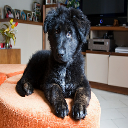

In [8]:
# 샘플 이미지 출력
image = image[0].numpy()*255.0
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

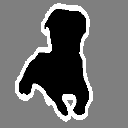

In [9]:
# 샘플 마스크 출력
mask = (mask[0]/2).numpy()*255.0
cv2_imshow(mask)

## U-Net 모델(인코더-디코더)

In [10]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
base_model.trainable=False

58900480/58889256 [==============================] - 1s 0us/step


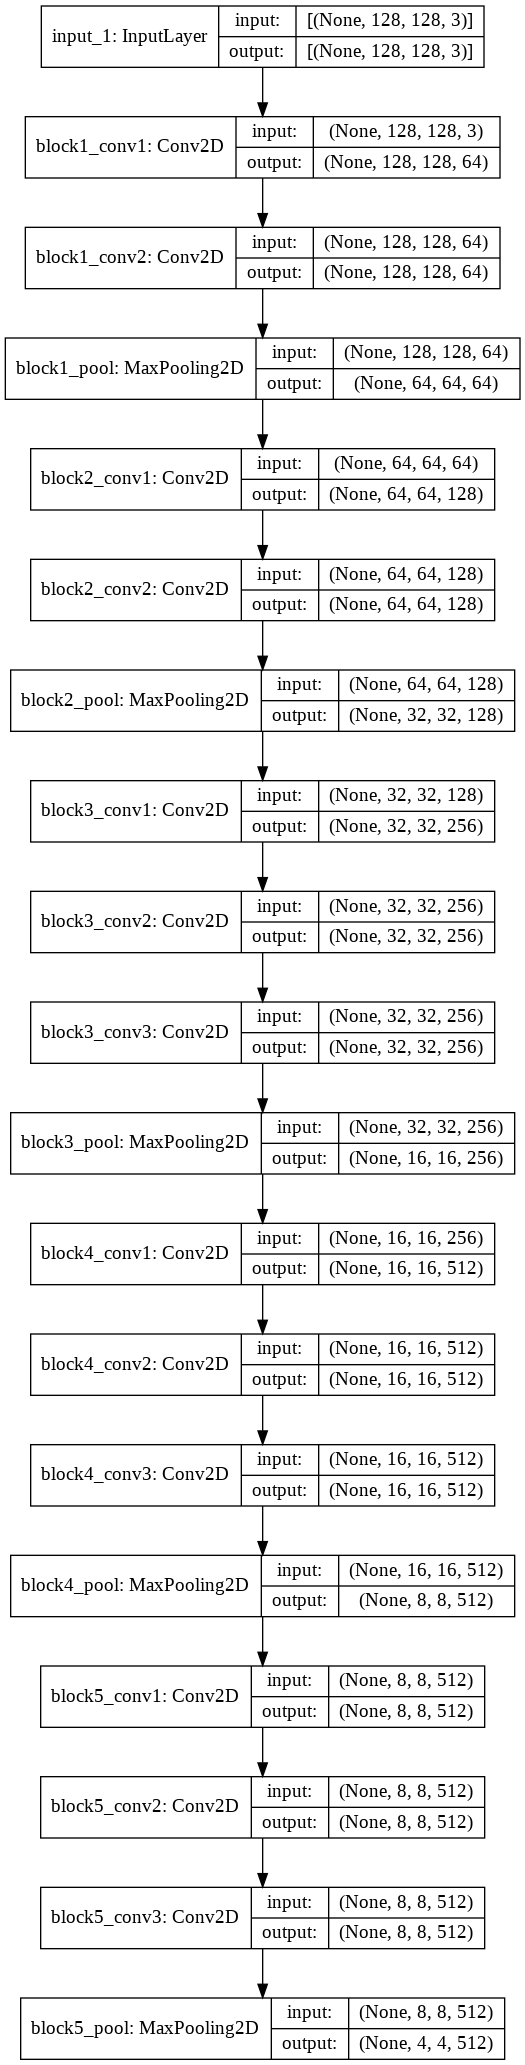

In [11]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

In [12]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.models.Model(inputs=base_model.input, 
                                outputs=[
                                         base_model.get_layer(name='block5_conv3').output,
                                         base_model.get_layer(name='block4_conv3').output,
                                         base_model.get_layer(name='block3_conv3').output,
                                         base_model.get_layer(name='block2_conv2').output,
                                         base_model.get_layer(name='block1_conv2').output,
                                ])

In [13]:
# U-Net 구조로 모델 정의

input_ =  tf.keras.layers.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(input_)

out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, (3,3), activation='elu', padding='same')(out) # 채널 이미지
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.models.Model(inputs=input_, outputs=out)

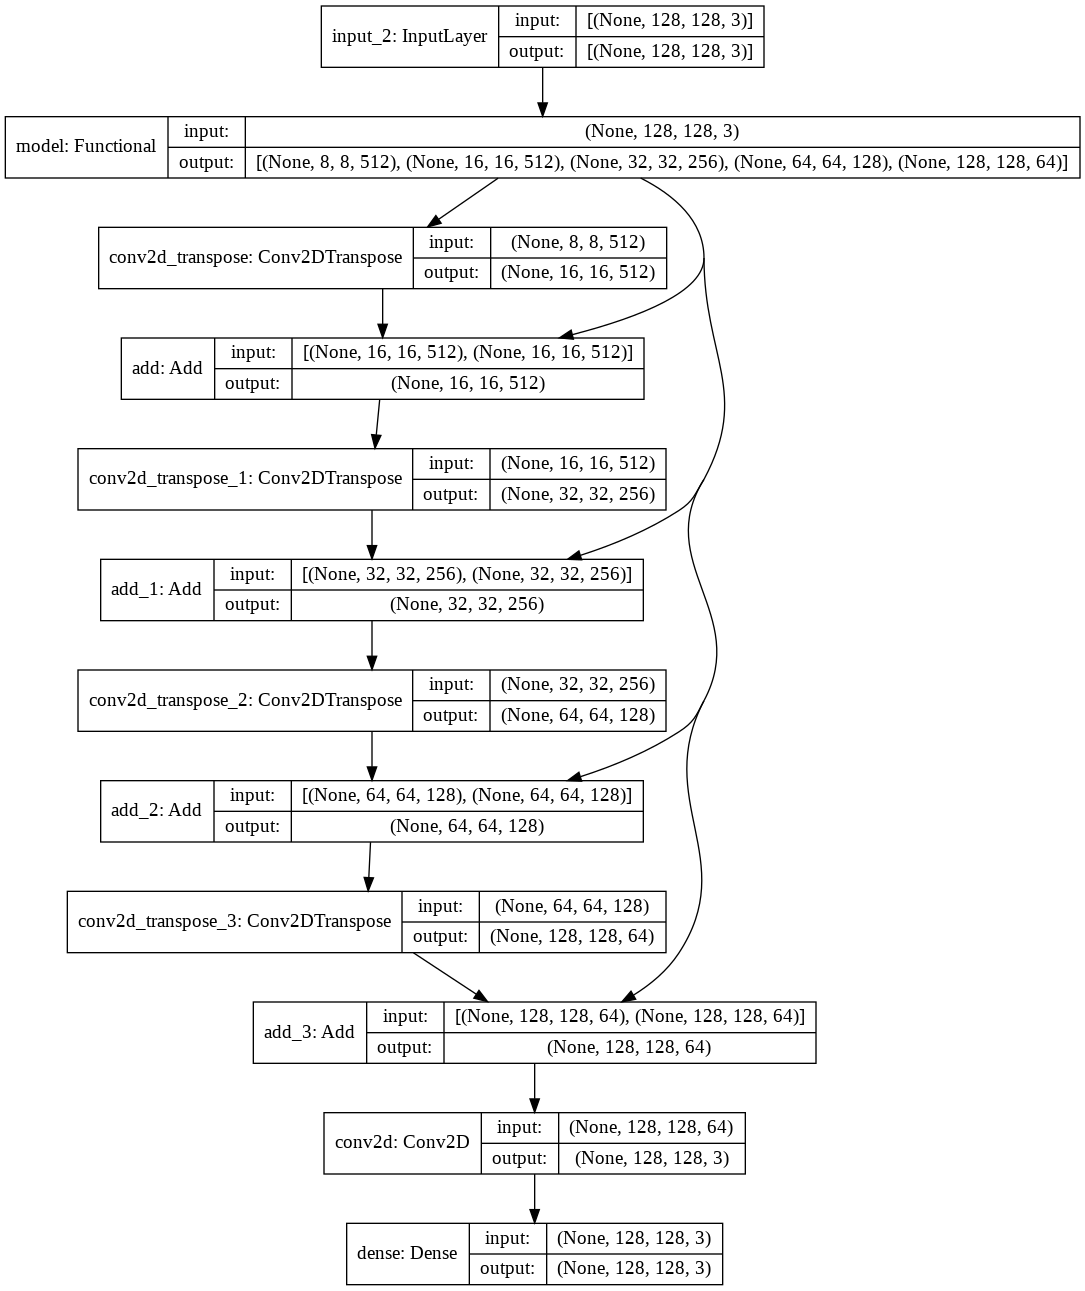

In [14]:
tf.keras.utils.plot_model(unet_model, show_shapes=True, show_layer_names=True)

In [15]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 8, 8, 512),  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 512)  2359808     model[0][0]                      
__________________________________________________________________________________________________
add (Add)                       (None, 16, 16, 512)  0           conv2d_transpose[0][0]           
                                                                 model[0][1]                

In [16]:
# 모델 컴파일
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
unet_model.fit(train_ds,
               epochs=epoch_num)

Epoch 1/20
230/230 [==============================] - 52s 70ms/step - loss: 0.7937 - acc: 0.6709
Epoch 2/20
230/230 [==============================] - 18s 71ms/step - loss: 0.5521 - acc: 0.7496
Epoch 3/20
230/230 [==============================] - 19s 71ms/step - loss: 0.5212 - acc: 0.7590
Epoch 4/20
230/230 [==============================] - 19s 71ms/step - loss: 0.5015 - acc: 0.7654
Epoch 5/20
230/230 [==============================] - 19s 72ms/step - loss: 0.4855 - acc: 0.7711
Epoch 6/20
230/230 [==============================] - 19s 73ms/step - loss: 0.4371 - acc: 0.8177
Epoch 7/20
230/230 [==============================] - 19s 73ms/step - loss: 0.4061 - acc: 0.8428
Epoch 8/20
230/230 [==============================] - 19s 73ms/step - loss: 0.3931 - acc: 0.8498
Epoch 9/20
230/230 [==============================] - 19s 74ms/step - loss: 0.3834 - acc: 0.8540
Epoch 10/20
230/230 [==============================] - 19s 74ms/step - loss: 0.3771 - acc: 0.8566
Epoch 11/20
230/230 [========

In [17]:
# 1개 배치(16개 이미지) 선택
image, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(image)

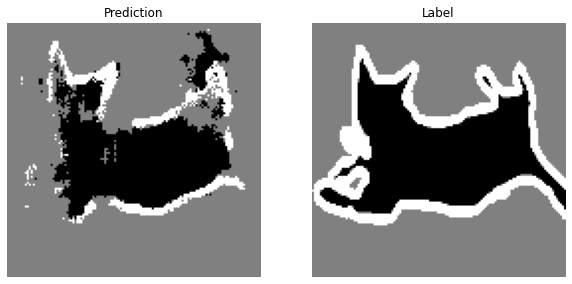

In [23]:
# 예측 이미지
pred_image = np.argmax(pred[15], axis=-1)

# 정답 이미지
label_image = mask[15].numpy()[:, :, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(pred_image, 'gray')
axes[0].axis('off')
axes[0].set_title('Prediction')

axes[1].imshow(label_image, 'gray')
axes[1].axis('off')
axes[1].set_title('Label')

plt.show()